# ML Approach

In [15]:
import pandas as pd 
from plotnine import (ggplot, aes, geom_line,facet_grid, theme_bw, labs)
from plotnine.options import set_option

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from mlforecast import MLForecast 

from utilsforecast.plotting import plot_series 
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import *

In [16]:
#Reading the data
df = pd.read_csv("../data/tidy_data.csv", parse_dates=[0])

In [17]:
TARGET = 'farmgate_milk_price'

## Data Splitting

In [18]:
#split the data such as the last 12 months are for validation
def train_valid_split(df:pd.DataFrame):
    train_df = df.iloc[:-12, :]
    valid_df = df.iloc[df.shape[0]-12:, :] 

    return train_df, valid_df

## Pre-processing

In [19]:
class Preprocess:

    def __init__(self, df: pd.DataFrame, date_col:str, target_col:str):
        self.df = df  
        self._raw = self.df.copy() 
        self.date_col = date_col 
        self.target_col = target_col 

    def __rename_columns(self):
        df_preprocessed = self.df.rename(columns={self.date_col: 'ds', self.target_col: 'y'}) 
        return df_preprocessed 

    def _create_id(self): 
        self.df.insert(0, 'unique_id', 0)

    def drop_nulls(self):
        self.df.dropna(axis=0, inplace=True) 
    
    def _preprocess(self):        
        self._create_id()
        self.drop_nulls()
        df_preprocessed = self.__rename_columns() 
        return df_preprocessed

In [20]:
engine = Preprocess(df, date_col='date', target_col='farmgate_milk_price') 
df_preprocessed = engine._preprocess() 

train_df, valid_df = train_valid_split(df_preprocessed)

In [21]:
#remove first 5 rows from Df 
train_df = train_df.iloc[5:, :]

## ML Models : Linear Regression, Random Forest and Bayesian Ridge

In [22]:
MODELS = [LinearRegression(), RandomForestRegressor(), BayesianRidge()]

mf = MLForecast(models=MODELS,
                freq='MS',
                num_threads=-1) 

c:\Users\heito\Desktop\projects\personal\milk-prediction\.venv\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.


In [23]:
model = mf.fit(train_df, static_features=[], fitted=True)

### Prediction on Validation Set

In [24]:
X_valid = valid_df.drop(columns=['y']) 
y_valid = valid_df['y'] 

y_preds = model.predict(12, X_df=X_valid)

## Evaluation

In [ ]:
#add y to predictions for evaluation
y_preds['y'] = y_valid.values

In [26]:
evaluate(y_preds, models=[obj.__class__.__name__ for obj in MODELS], metrics=[bias, mae, rmse])

,unique_id,metric,LinearRegression,RandomForestRegressor,BayesianRidge
0,0,bias,0.058678,0.003084,0.059674
1,0,mae,0.078254,0.124297,0.068028
2,0,rmse,0.105199,0.142435,0.093183


From our evaluation, we can see that the plain **Linear Regression** as we had already seen on notebook `02-Regression.ipynb` turns out to be one of the best models as long as the **Bayesian Ridge Regression**.

With that in mind, we can visualize some of our predictions in validation set.

## Visualizing Predictions

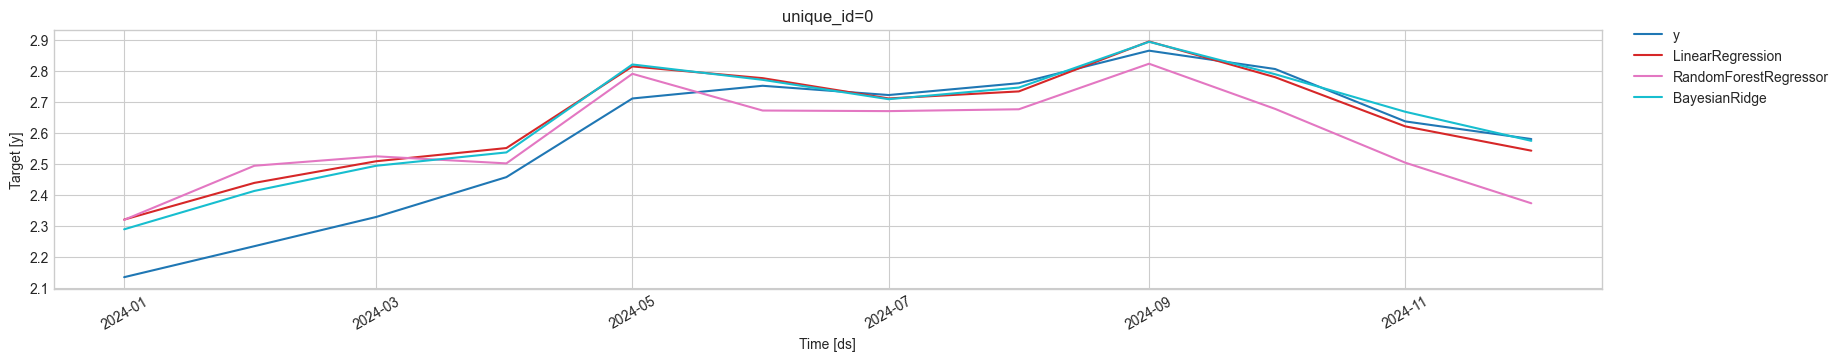

In [27]:
plt.style.use("seaborn-v0_8-whitegrid")
plot_series(forecasts_df=y_preds, plot_random=False, engine='matplotlib')

We can notice that all models sort of miss to approximate really well the behaviour of the validation set in the first four months. After that, 

## Saving an artefact of the model

When we get into the prediction phase we'll have to use this fitted model to predict our future dataframe with the values from 2025. 

That being said, we can train our model with the data from 2015 to 2024 - we no longer need to set-aside a validation set - and save its parameters so we can reuse it later on, without having to refit a new model.

In [10]:
engine = Preprocess(df, date_col='date', target_col='farmgate_milk_price') 
df_new = engine._preprocess() 

#remove the rows from 2014 
df_new = df_new.iloc[5:, :]

In [11]:
df_new

,unique_id,ds,milk_production,imports,exports,total_supply,population,per_capita_supply,unemployment,wage_mass,uht_milk_industry,uht_milk_market,y
96,0,2015-01-01,2207.717,76.124591,7.841312,2276.000278,201.607386,11.289270,0.069,165165.0,1.568627,2.415308,0.8382
97,0,2015-02-01,1899.716,63.763030,18.751395,1944.727635,201.740096,9.639768,0.075,165635.0,1.697815,2.350578,0.8554
98,0,2015-03-01,2027.962,94.259803,35.319605,2086.902199,201.872805,10.337708,0.080,165516.0,2.018438,2.377374,0.8942
99,0,2015-04-01,1851.024,93.138128,24.001814,1920.160314,202.005514,9.505485,0.081,161719.0,1.976786,2.519066,0.9334
100,0,2015-05-01,1886.178,97.944205,17.471481,1966.650725,202.138224,9.729237,0.083,162437.0,2.049296,2.602447,0.9537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0,2024-08-01,2113.325,182.746394,4.064448,2292.006946,212.653524,10.778128,0.066,329597.0,4.413439,5.269147,2.7607
212,0,2024-09-01,2104.908,182.145888,4.946605,2282.107283,212.723298,10.728055,0.064,331920.0,4.856938,5.339753,2.8657
213,0,2024-10-01,2198.885,203.342972,4.438911,2397.789061,212.793072,11.268173,0.062,335354.0,4.452080,5.410238,2.8065
214,0,2024-11-01,2227.416,204.272884,4.789603,2426.899280,212.862846,11.401235,0.061,338086.0,4.105220,5.304197,2.6374


## Model Fitting

We'll just keep the Linear Regression and the Bayesian Ridge which end up being the best models. 


In [12]:
MODELS = [LinearRegression(), BayesianRidge()]

mf = MLForecast(models=MODELS,
                freq='MS',
                num_threads=-1) 

c:\Users\heito\Desktop\projects\personal\milk-prediction\.venv\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.


In [13]:
final_model = mf.fit(df_new, static_features=[], fitted=True)

In [14]:
final_model.save("../models")